In [1]:
import os
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from cmcrameri import cm

In [2]:
folder_misc = "../../multiscale-personalized-models/misc/"

In [3]:
with open(os.path.join(folder_misc, "palette-okabe-ito.json")) as f:
    palette = json.loads(f.read())
    palette["groups"] = {int(k): v for k, v in palette["groups"].items()}

In [4]:
with open(os.path.join(folder_misc, "name_maps.json")) as f:
    name_maps = json.loads(f.read())

In [5]:
plt.style.use(os.path.join(folder_misc, "paper.mplstyle"))

In [6]:
from matplotlib.colors import ListedColormap


def create_cmap(color, n_colors=256):
    
    colors = np.ones((n_colors, 4))
    ones = np.ones(len(color))
    color = np.asarray(color)

    for i in range(n_colors):
        α = i / n_colors
        c = α * color + (1 - α) * ones
        colors[i, :-1] = c

    cmap = ListedColormap(colors)
    
    return cmap

In [7]:
def rescale(x):
    return (x - np.min(x)) / np.ptp(x)


def create_markup(df, α=1.1):
    counts = df.period.value_counts()
    counts = (counts * 10 / counts.index > α) & (counts.index > 0)
    counts = counts.astype(float)
    result = df.copy()
    result["proba"] = result.period.replace(counts)
    return result

In [8]:
filename = "../data/synthetic-latest.csv"
df = pd.read_csv(filename)

df_sample = df[2700: 4000].copy()
df_sample = create_markup(df_sample)

# filename_sample = "../data/synthetic-sample.csv"
# df_sample = pd.read_csv(filename_sample)
df_sample.head()

,x,y,z,period,proba
2700,-1.532737,-251.306018,-91.542163,0.0,0.0
2701,-1.278394,-251.180729,-91.094284,0.0,0.0
2702,-1.001983,-251.041610,-90.663017,0.0,0.0
2703,-0.718477,-250.921989,-90.229613,0.0,0.0
2704,-0.409787,-250.807903,-89.811278,0.0,0.0


In [9]:
from sklearn.metrics import euclidean_distances


def create_sample(df, α=1.1):

    n = len(df)
    xyz = ["x", "y", "z"]

    image = euclidean_distances(df[xyz])
    image /= 100

    counts = df.period.value_counts()
    counts = (counts * 10 / counts.index > α) & (counts.index > 0)

    mask = np.zeros((n, n))
    for p in df.period.unique():
        if p == 0:
            continue
        if not counts[p]:
            continue
        m = (df.period == p).astype(float)
        m = np.tile(m, (len(m), 1))
        m = m * m.T
        mask = mask + m

    return image, mask

In [10]:
image, mask = create_sample(df_sample)
image /= image.max()

(-0.5, 1299.5, 1299.5, -0.5)

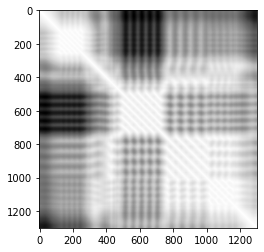

In [11]:
# plt.figure(dpi=200)
# plt.imshow(image[125: 250, 125: 250], cmap="Greys")
plt.imshow(image, cmap="Greys")

# plt.imshow(mask, alpha=0.3)

plt.axis()

In [12]:
starts = np.nonzero((df_sample.proba.diff() > 0).values)[0].tolist()
ends = np.nonzero((df_sample.proba.diff() < 0).values)[0].tolist()

In [13]:
colors = palette["okabe_ito"]
color_proba = np.asarray(colors[4])
cmap_proba = cm.oslo_r  # "" # cm.oslo_r
vmin = 0
vmax = 2

In [14]:
N = len(image)

In [15]:
cmap_proba = create_cmap(color_proba)

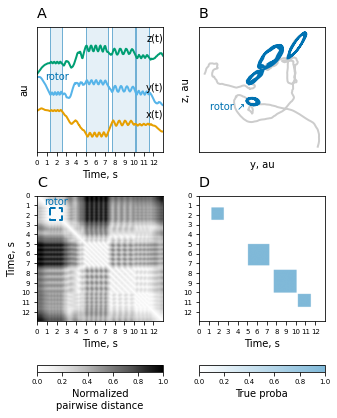

In [16]:
height_percents = [0.06, 1, 1]
height_percents = np.array(height_percents) / np.sum(height_percents)
space_w = 0.1
space_h = 0.1

width = (1 - space_w * 3) / 2
heights = [(1 - space_h * 4) * h for h in height_percents]

aspect = heights[1] / width

fig_height = 6
fig_width = fig_height * aspect

fig = plt.figure(
    figsize=(fig_width, fig_height),
    # facecolor="aliceblue"
)

bottom = space_h

for i in range(len(heights)):
    axes_row = []
    for j in range(2):
        
        left = space_w + (width + space_w) * j
        width = width
        
        height = heights[i]
        
        pos = [left, bottom, width, height]
        plt.axes(pos)
                
    bottom += height + space_h

axes = np.array(fig.axes).reshape(-1, 2)


#################
#################


lw = 2

plt.sca(axes[2, 0])

for i, c in enumerate("xyz"):
    # x = df_sample.index
    color = colors[i]
    y = rescale(df_sample[c]) * 0.9 + i
    y = np.array(y)
    x = np.arange(len(y)) / 100
    plt.plot(x, y, lw=lw, color=color) # , c=df_sample.proba, vmin=0, vmax=1)
    plt.text(x[-1], y[-1] + 0.4, f"{c}(t)", va="bottom", ha="right")
    
color = "0.8"    

for i1, i2 in zip(starts, ends):
    i1, i2 = i1 / 100, i2 / 100
    params = {"zorder": -10, "lw": 0.5, "color": color_proba}
    plt.axvline(i1, **params)
    plt.axvline(i2, **params)
    plt.axvspan(i1, i2, **params, alpha=0.1)
    
plt.text(2, 1.8, "rotor", ha="center", color=color_proba)


au = "arbitrary units"
au = "AU"
au = "au"

plt.yticks([])
plt.ylabel(au)

# xticks = np.arange(0, N, 100)
# plt.xticks(xticks, xticks / 100)

plt.xticks(
    np.arange(0, 15, 1),
    # np.arange(0, N // 100, 1).astype(int),
    size="x-small"
)
    
plt.xlabel("Time, s")

plt.xlim(x[0], x[-1])
plt.ylim(-0.5, 3.5)


##################################

plt.sca(axes[2, 1])


cx, cy = "y", "z"
proba = df_sample.proba.values
x = rescale(df_sample[cx])
y = rescale(df_sample[cy])

for p in 0, 1:
    
    if p:
        alpha = 1
        color = color_proba
    else:
        alpha = 0.2
        color = "k"
    
    x_ = x.copy()
    y_ = y.copy()
    
    x_[proba != p] = np.NaN
    y_[proba != p] = np.NaN

    plt.plot(
        x_,
        y_,
        color=color,
        alpha=alpha,
        lw=2
    )
    
plt.text(0.05, 0.32, "rotor ↗", color=color_proba)

plt.xticks([])
plt.xlabel(f"{cx}, {au}")
plt.yticks([])
plt.ylabel(f"{cy}, {au}")


###########

plt.sca(axes[1, 0])
ims = plt.imshow(image, cmap="Greys")

i, j = starts[0], ends[0]
x = [i, i, j, j, i]
y = [i, j, j, i, i]
plt.plot(x, y, "--", c=color_proba, lw=2)
plt.text(
    (i + j) / 2,
    i - 10,
    "rotor",  # ←
    c=color_proba,
    va="bottom",
    ha="center",
    # weight="bold"
    # bbox=dict(facecolor='white', alpha=0.5, edgecolor=None)
    
)

plt.ylabel("Time, s")

plt.colorbar(
    ims,
    cax=axes[0, 0],
    orientation="horizontal",
    ticks=np.linspace(0, 1, 6),
) 

plt.sca(axes[0, 0])
plt.xlabel("Normalized\npairwise distance")
plt.xlim(0, 1)
plt.xticks(np.linspace(0, 1, 6), size="x-small")

# axes[1, 1].imshow(image, cmap="Greys")
ims = axes[1, 1].imshow(
    mask,
    cmap=cmap_proba,
    vmin=vmin,
    vmax=vmax,
    alpha=1
)

plt.colorbar(
    ims,
    cax=axes[0, 1],
    orientation="horizontal",
    ticks=np.linspace(0, 1, 6),
) 

plt.sca(axes[0, 1])
plt.xlabel("True proba")
plt.xlim(0, 1)
plt.xticks(np.linspace(0, 1, 6), size="x-small")


for ax in axes[1].flatten():
    plt.sca(ax)
    plt.xticks(
        np.arange(0, N, 100),
        np.arange(0, N // 100, 1).astype(int),
        size="x-small"
    )
    plt.yticks(
        np.arange(0, N, 100),
        np.arange(0, N // 100, 1).astype(int),
        size="x-small"
    )
    plt.xlabel("Time, s")
    

letters = "ABCD"
for ax, letter in zip(axes[1:][::-1].flatten(), letters):
    ax.tick_params(axis="x", labelsize="x-small")
    ax.tick_params(axis="y", labelsize="x-small")
    
    letter_margin_x = 0.0
    letter_margin_y = 0.02
    letter_params = dict(
        weight="normal",
        size="x-large"
    )
    
    pos = ax.get_position()

    fig.text(
        pos.xmin - letter_margin_x,
        pos.ymax + letter_margin_y,
        letter,
        **letter_params
    )
    
    
# plt.savefig(
#     "../images/synthetic-rotors-v2.png",
#     facecolor="white",
#     bbox_inches="tight",
#     dpi=300
# )